# Market Segmentation with Worldwide COVID-19 Vaccinations

In [1]:
'''Things to do:
- map plot
-pca
- k means clustering
    - elbow plot
- hierarchical agglomerative clustering
    - dendrogram
- metrics
    - silhouette coefficient
    b- calinski harabasz score


do it all with large dataset?
 - remove columns missing lots of data
 - keep all vaccination data, drop null values from there
 - run pca and stuff
''' 


'Things to do:\n- map plot\n-pca\n- k means clustering\n    - elbow plot\n- hierarchical agglomerative clustering\n    - dendrogram\n- metrics\n    - silhouette coefficient\n    b- calinski harabasz score\n\n'

## Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

pd.set_option('display.max_columns', None)

## Data Loading and Cleaning

In [3]:
data = pd.read_csv('../data/vaccinations_all.csv')

In [4]:
data.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10782 entries, 0 to 10781
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   location                             10782 non-null  object 
 1   iso_code                             10782 non-null  object 
 2   date                                 10782 non-null  object 
 3   total_vaccinations                   6807 non-null   float64
 4   people_vaccinated                    6183 non-null   float64
 5   people_fully_vaccinated              4448 non-null   float64
 6   daily_vaccinations_raw               5806 non-null   float64
 7   daily_vaccinations                   10591 non-null  float64
 8   total_vaccinations_per_hundred       6807 non-null   float64
 9   people_vaccinated_per_hundred        6183 non-null   float64
 10  people_fully_vaccinated_per_hundred  4448 non-null   float64
 11  daily_vaccinations_per_milli

In [6]:
data.isnull().sum()

location                                  0
iso_code                                  0
date                                      0
total_vaccinations                     3975
people_vaccinated                      4599
people_fully_vaccinated                6334
daily_vaccinations_raw                 4976
daily_vaccinations                      191
total_vaccinations_per_hundred         3975
people_vaccinated_per_hundred          4599
people_fully_vaccinated_per_hundred    6334
daily_vaccinations_per_million          191
dtype: int64

In [7]:
#remove anything that isn't a country
# create list of things that are not countries 
continents = ['North America', 'Europe', 'Asia','European Union', 
              'Africa', 'South America', 'World', 'United Kingdom']

data = data[~data['location'].isin(continents)]

In [8]:
data.location.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Bermuda', 'Bhutan',
       'Bolivia', 'Brazil', 'Brunei', 'Bulgaria', 'Cambodia', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Chile', 'China', 'Colombia',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Faeroe Islands', 'Falkland Islands', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece',
       'Greenland', 'Grenada', 'Guatemala', 'Guernsey', 'Guinea',
       'Guyana', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Isle of Man', 'Israel',
       'Italy', 'Jamai

In [9]:
# drop columns that have been 'smoothed' or have some kind of calculation using 'per'
cols = [data.drop(columns= i, inplace= True) for i in data.columns if 'per' in i]

In [10]:
# fill null values with 0
data.fillna(0, inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9926 entries, 0 to 10781
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location                 9926 non-null   object 
 1   iso_code                 9926 non-null   object 
 2   date                     9926 non-null   object 
 3   total_vaccinations       9926 non-null   float64
 4   people_vaccinated        9926 non-null   float64
 5   people_fully_vaccinated  9926 non-null   float64
 6   daily_vaccinations_raw   9926 non-null   float64
 7   daily_vaccinations       9926 non-null   float64
dtypes: float64(5), object(3)
memory usage: 697.9+ KB


### Add Country Income Data

In [11]:
# open file from World Bank that contains data on income classifications
country_incomes = pd.read_csv('../data/list-of-economies.csv', 
                              header= 4, index_col= False)
country_incomes

,Unnamed: 0,Economy,Code,Region,Income group,Lending category,Other
0,1.0,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
1,2.0,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
2,3.0,Algeria,DZA,Middle East & North Africa,Lower middle income,IBRD,NaN
3,4.0,American Samoa,ASM,East Asia & Pacific,Upper middle income,..,NaN
4,5.0,Andorra,AND,Europe & Central Asia,High income,..,NaN
...,...,...,...,...,...,...,...
261,42.0,Sub-Saharan Africa,SSF,NaN,NaN,NaN,NaN
262,43.0,Sub-Saharan Africa (excluding high income),SSA,NaN,NaN,NaN,NaN
263,44.0,Sub-Saharan Africa (IDA & IBRD),TSS,NaN,NaN,NaN,NaN
264,45.0,Upper middle income,UMC,NaN,NaN,NaN,NaN


In [12]:
# drop unnecessary / mostly empty columns
country_incomes.drop(columns= ['Unnamed: 0', 'Other', 'Lending category'], inplace= True)

In [13]:
# subset data and check it worked
country_incomes = country_incomes.iloc[:218]
country_incomes.tail()

,Economy,Code,Region,Income group
213,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income
214,West Bank and Gaza,PSE,Middle East & North Africa,Lower middle income
215,"Yemen, Rep.",YEM,Middle East & North Africa,Low income
216,Zambia,ZMB,Sub-Saharan Africa,Lower middle income
217,Zimbabwe,ZWE,Sub-Saharan Africa,Lower middle income


In [14]:
country_incomes.Region.value_counts()

Europe & Central Asia         58
Sub-Saharan Africa            48
Latin America & Caribbean     42
East Asia & Pacific           38
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: Region, dtype: int64

In [15]:
country_incomes.isnull().sum()

Economy         0
Code            0
Region          0
Income group    0
dtype: int64

In [16]:
# merge dataframes
df = pd.merge(data, country_incomes, how= 'left', left_on= 'iso_code', right_on= 'Code')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9926 entries, 0 to 9925
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location                 9926 non-null   object 
 1   iso_code                 9926 non-null   object 
 2   date                     9926 non-null   object 
 3   total_vaccinations       9926 non-null   float64
 4   people_vaccinated        9926 non-null   float64
 5   people_fully_vaccinated  9926 non-null   float64
 6   daily_vaccinations_raw   9926 non-null   float64
 7   daily_vaccinations       9926 non-null   float64
 8   Economy                  9045 non-null   object 
 9   Code                     9045 non-null   object 
 10  Region                   9045 non-null   object 
 11  Income group             9045 non-null   object 
dtypes: float64(5), object(7)
memory usage: 1008.1+ KB


In [17]:
# Income group must be filled in
# See which countries have null income group 
null_vals = df[df.isnull().any(axis= 1)]
null_vals.location.unique()

array(['Anguilla', 'England', 'Falkland Islands', 'Guernsey', 'Jersey',
       'Kosovo', 'Montserrat', 'Northern Cyprus', 'Northern Ireland',
       'Oceania', 'Saint Helena', 'Scotland', 'Wales'], dtype=object)

Research if Australia and Oceania have the same stats.

In [19]:
day = df[df['date'] == '2021-04-05']

In [20]:
df[(df['location'] == 'Oceania') & \
             (df['date'] == '2021-04-05')]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,Economy,Code,Region,Income group
6872,Oceania,OWID_OCE,2021-04-05,912975.0,211477.0,16483.0,1127.0,47102.0,NaN,NaN,NaN,NaN


In [21]:
df[(df['location'] == 'Australia') & \
             (df['date'] == '2021-04-05')]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,Economy,Code,Region,Income group
459,Australia,AUS,2021-04-05,844309.0,0.0,0.0,1127.0,43221.0,Australia,AUS,East Asia & Pacific,High income


From this, we see that Australia is collecting it's own stats that are combined with other countries to form Oceania.

The 14 countries within Oceania are listed in the income csv, but range from Solomon Islands and Papua New Guinea as lower middle, Fiji and Samoa as upper middle, and New Zealand and Australia as high.

Most of the countries are labeled 'Upper middle income', so we will replace the Income group with that.

In [22]:
# replace null values with correct values
df.loc[df['location'] == 'Oceania', ['Region', 'Income group']] = \
'East Asia & Pacific', 'Upper middle income'

In [23]:
df[df['location'] == 'Oceania'][:5]

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,Economy,Code,Region,Income group
6823,Oceania,OWID_OCE,2021-02-15,0.0,0.0,0.0,0.0,0.0,NaN,NaN,East Asia & Pacific,Upper middle income
6824,Oceania,OWID_OCE,2021-02-16,0.0,0.0,0.0,0.0,0.0,NaN,NaN,East Asia & Pacific,Upper middle income
6825,Oceania,OWID_OCE,2021-02-17,0.0,0.0,0.0,0.0,0.0,NaN,NaN,East Asia & Pacific,Upper middle income
6826,Oceania,OWID_OCE,2021-02-18,0.0,0.0,0.0,0.0,0.0,NaN,NaN,East Asia & Pacific,Upper middle income
6827,Oceania,OWID_OCE,2021-02-19,30.0,30.0,0.0,30.0,8.0,NaN,NaN,East Asia & Pacific,Upper middle income


Fill in Kosovo with it's respective stats and Northern Cyprus with Turkey's stats

In [24]:
df.loc[df['location'] == 'Northern Cyprus', ['Region', 'Income group']] = \
'Europe & Central Asia', 'Upper middle income'

In [25]:
df.loc[df['location'] == 'Kosovo', ['Region', 'Income group']] = \
'Europe & Central Asia', 'Upper middle income'

The rest of the countries are territories that belong to the UK. We will fill the stats in with UK information. See the EDA notebook for more information on the reasoning behind this.

In [26]:
df['Income group'].fillna('High income', inplace= True)
df['Region'].fillna('Europe & Central Asia', inplace= True)

In [30]:
df.iso_code.unique()

array(['AFG', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG', 'AUS',
       'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ',
       'BMU', 'BTN', 'BOL', 'BRA', 'BRN', 'BGR', 'KHM', 'CAN', 'CPV',
       'CYM', 'CHL', 'CHN', 'COL', 'CRI', 'CIV', 'HRV', 'CYP', 'CZE',
       'DNK', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'OWID_ENG', 'GNQ', 'EST',
       'FRO', 'FLK', 'FIN', 'FRA', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA',
       'GIB', 'GRC', 'GRL', 'GRD', 'GTM', 'GGY', 'GIN', 'GUY', 'HND',
       'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN',
       'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'OWID_KOS',
       'KWT', 'LAO', 'LVA', 'LBN', 'LIE', 'LTU', 'LUX', 'MAC', 'MWI',
       'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS', 'MEX', 'MDA', 'MCO',
       'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL', 'NLD',
       'NZL', 'NGA', 'MKD', 'OWID_CYN', 'OWID_NIR', 'NOR', 'OWID_OCE',
       'OMN', 'PAK', 'PSE', 'PAN', 'PRY', 'PER', 'PHL', 'POL', 'PRT',
       'Q

The data source made up some codes that don't actually exist. To prevent any slip-ups, let's remove the "OWID_" so all entries have 3-letter codes.

In [31]:
df['iso_code'] = df['iso_code'].str.replace('OWID_', '')

In [33]:
df.drop(['Economy', 'Code'], axis= 1, inplace= True)

In [34]:
df.isnull().sum()

location                   0
iso_code                   0
date                       0
total_vaccinations         0
people_vaccinated          0
people_fully_vaccinated    0
daily_vaccinations_raw     0
daily_vaccinations         0
Region                     0
Income group               0
dtype: int64

## PCA, K-Means, and Hierarchical Agglomerative Clustering

In [28]:
# deal with null / missing values
# PCA
# Cluster

<AxesSubplot:>

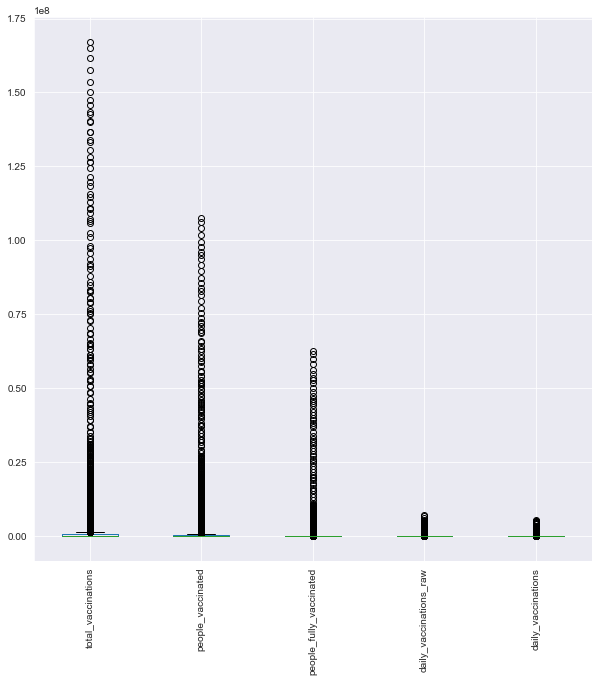

In [35]:
df.boxplot(figsize= (10,10), rot= 90)

<AxesSubplot:>

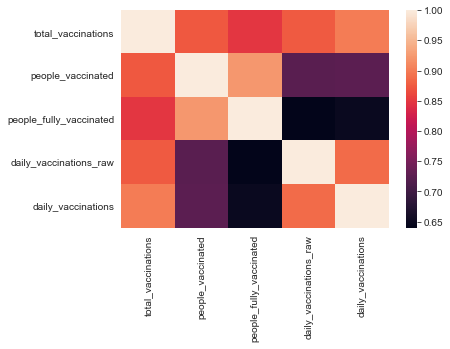

In [36]:
sns.heatmap(df.corr())

In [38]:
num_df = df.loc[:, df.dtypes == np.float64]

In [39]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(num_df)

In [90]:
pca = PCA()
X_pca = pca.fit_transform(scaled_df)

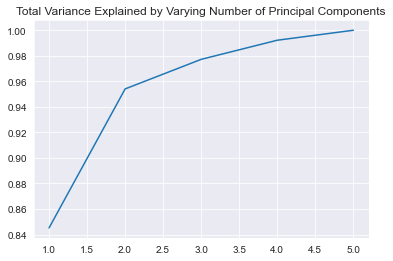

In [93]:
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum())
plt.title('Total Variance Explained by Varying Number of Principal Components');

### K-Means Clustering

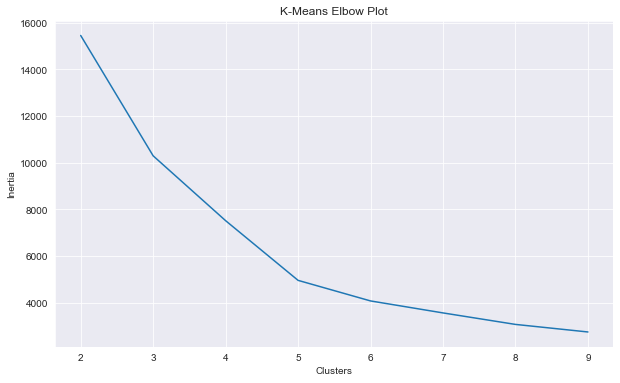

In [69]:
# find right amount of clusters
results = []
N = range(2,10)
for n in N:
    model = KMeans(n_clusters= n, random_state= 27)
    model.fit(pca_df)
    results.append(model.inertia_)
    
# plot elbow plot
plt.figure(figsize= (10, 6))
plt.plot(N, results)
plt.title('K-Means Elbow Plot')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()

K-Means using 5 clusters

In [85]:
# unscaled, original data
k_means_orig = KMeans(n_clusters = 5)
k_means_orig.fit(num_df)
cluster_preds = k_means_orig.predict(num_df)

CH_score = calinski_harabasz_score(num_df, cluster_preds)
CH_score

30587.726880711285

In [87]:
cluster_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

TypeError: '(array([ True,  True,  True, ...,  True,  True,  True]), 0)' is an invalid key

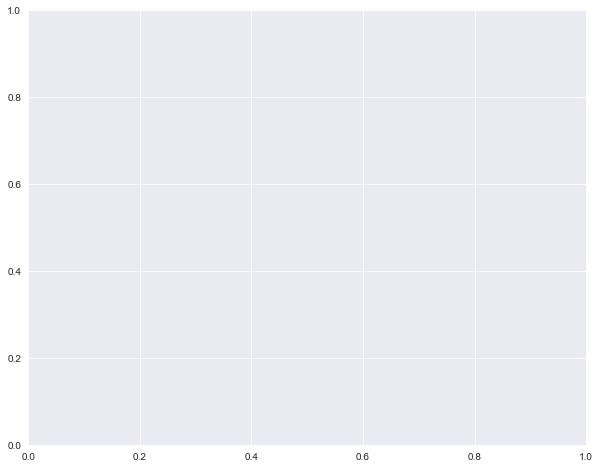

In [86]:
# visualize the clusters
plt.subplots(figsize= (10, 8))
plt.scatter(num_df[cluster_preds == 0, 0], num_df[cluster_preds == 0, 1], s= 20, label= 'Cluster 1')
plt.scatter(num_df[cluster_preds == 1, 0], num_df[cluster_preds == 1, 1], s= 20, label= 'Cluster 2')
plt.scatter(num_df[cluster_preds == 2, 0], num_df[cluster_preds == 2, 1], s= 20, label= 'Cluster 3')
plt.scatter(num_df[cluster_preds == 3, 0], num_df[cluster_preds == 3, 1], s= 20, label= 'Cluster 4')
plt.scatter(num_df[cluster_preds == 4, 0], num_df[cluster_preds == 4, 1], s= 20, label= 'Cluster 5')

plt.scatter(k_means_orig.cluster_centers_[:, 0], k_means_orig.cluster_centers_[:, 1], s= 50, label= 'Centroid')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

In [66]:
# scaled data
k_means = KMeans(n_clusters = 5)
k_means.fit(scaled_df)
cluster_preds = k_means.predict(scaled_df)

CH_score = calinski_harabasz_score(scaled_df, cluster_preds)
CH_score

18971.500522092774

In [88]:
# pca and scaled data
k_means_pca = KMeans(n_clusters = 5)
k_means_pca.fit(pca_df)
cluster_preds = k_means_pca.predict(pca_df)

CH_score = calinski_harabasz_score(pca_df, cluster_preds)
CH_score

21761.04992732559

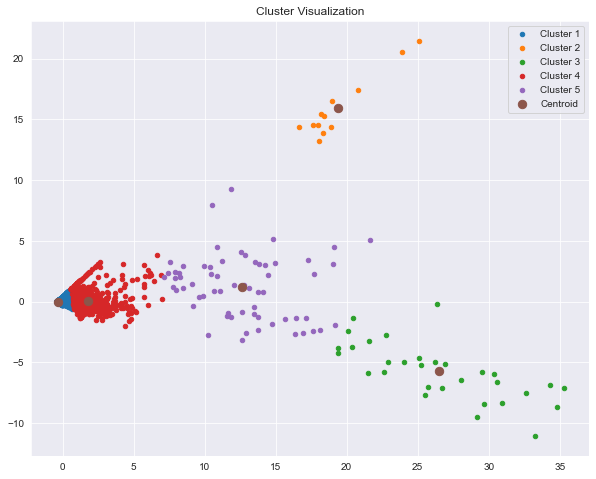

In [82]:
# visualize the clusters
plt.subplots(figsize= (10, 8))
plt.scatter(pca_df[cluster_preds == 0, 0], pca_df[cluster_preds == 0, 1], s= 20, label= 'Cluster 1')
plt.scatter(pca_df[cluster_preds == 1, 0], pca_df[cluster_preds == 1, 1], s= 20, label= 'Cluster 2')
plt.scatter(pca_df[cluster_preds == 2, 0], pca_df[cluster_preds == 2, 1], s= 20, label= 'Cluster 3')
plt.scatter(pca_df[cluster_preds == 3, 0], pca_df[cluster_preds == 3, 1], s= 20, label= 'Cluster 4')
plt.scatter(pca_df[cluster_preds == 4, 0], pca_df[cluster_preds == 4, 1], s= 20, label= 'Cluster 5')

plt.scatter(k_means_pca.cluster_centers_[:, 0], k_means_pca.cluster_centers_[:, 1], s= 70, label= 'Centroid')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

### Hierarchical Agglomerative Clustering

In [53]:
hac = AgglomerativeClustering(n_clusters= 2)
hac.fit(num_df)
hac_preds = hac.labels_

CH_score = calinski_harabasz_score(num_df, hac_preds)
CH_score

25194.772506373734

In [57]:
hac = AgglomerativeClustering(n_clusters= 2)
hac.fit(scaled_df)
hac_preds = hac.labels_

CH_score = calinski_harabasz_score(scaled_df, hac_preds)
CH_score

19748.40320091099

In [56]:
hac = AgglomerativeClustering(n_clusters= 2)
hac.fit(pca_df)
hac_preds = hac.labels_

CH_score = calinski_harabasz_score(pca_df, hac_preds)
CH_score

20725.93570611157